In [56]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False)


In [57]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(117, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Should add metric=[...]
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [58]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [59]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 133426 images belonging to 117 classes.
Found 29568 images belonging to 117 classes.


In [60]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.3

class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)

class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Andorra: 0.0
Gibraltar: 0.0
Macao: 0.0
United States of America: 2.9057695986892125e-05
France: 8.344396120565337e-05
India: 9.55625819465994e-05
Russian Federation: 9.586520065482582e-05
Brazil: 0.00010672632044770321
Canada: 0.00010710907888449756
Australia: 0.00012372406560978057
Italy: 0.00014128465883203552
Japan: 0.00014257134182767625
Spain: 0.00014584630343273089
Thailand: 0.0001478428348578916
U.K. of Great Britain and Northern Ireland: 0.00014957805562854738
Poland: 0.00015992979733359786
Sweden: 0.00017512783281737137
Mexico: 0.00018267979315463997
Indonesia: 0.0001849931621297275
Norway: 0.00024145148022830802
Argentina: 0.00024765172569301863
Finland: 0.00026106835998124055
South Africa: 0.00028708290945587636
Turkey: 0.0002956666891858952
Ireland: 0.00030883053615828005
Philippines: 0.00031893339218470906
Romania: 0.0003313112048197736
Czech Republic: 0.00035551746146138063
New Zealand: 0.0003687944130276977
Portugal: 0.000411461313697229
Denmark: 0.0004135639313169792
Gr

C:\Users\21thebes\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [61]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=20,
    class_weight = class_weights)


Epoch 1/2
100/100 [==============================] - 326s 3s/step - loss: 9.5922e-04 - val_loss: 3.6600
Epoch 2/2
100/100 [==============================] - 377s 4s/step - loss: 0.0011 - val_loss: 3.9639


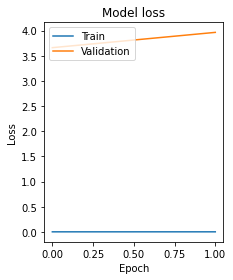

In [62]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [63]:
model.save('my_model.h5')


C:\Users\21thebes\AppData\Roaming\Python\Python36\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\val'
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

class_names = generator.class_indices.keys()
print(class_names)


Found 29568 images belonging to 117 classes.
dict_keys(['Albania', 'American Samoa', 'Andorra', 'Argentina', 'Australia', 'Austria', 'Azores Islands', 'Bangladesh', 'Belarus', 'Belgium', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia & Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Guam', 'Guatemala', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Lithuania', 'Luxembourg', 'Macao', 'Madagascar', 'Madeira Islands', 'Malaysia', 'Malta', 'Mexico', 'Mongolia', 'Montenegro', 'Myanmar', 'Nepal', 'Netherlands', 'Netherlands A

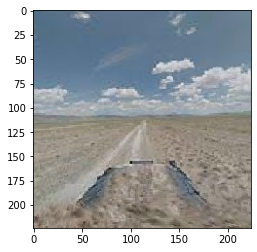

Country: ['United States of America'], Probability: 0.027915583923459053
Country: ['France'], Probability: 0.02308526635169983
Country: ['Brazil'], Probability: 0.02230571024119854
Country: ['Czech Republic'], Probability: 0.022156493738293648
Country: ['Sweden'], Probability: 0.02157001383602619
Country: ['Canada'], Probability: 0.020429352298378944
Country: ['India'], Probability: 0.018736740574240685
Country: ['Thailand'], Probability: 0.018684903159737587
Country: ['Russian Federation'], Probability: 0.018296638503670692
Country: ['Indonesia'], Probability: 0.01733461022377014
Country: ['Portugal'], Probability: 0.016818534582853317
Country: ['Argentina'], Probability: 0.016666123643517494
Country: ['Spain'], Probability: 0.016471093520522118
Country: ['Japan'], Probability: 0.015954697504639626
Country: ['U.K. of Great Britain and Northern Ireland'], Probability: 0.015927474945783615
Country: ['Mexico'], Probability: 0.015877848491072655
Country: ['Finland'], Probability: 0.015608

In [65]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Mongolia\-HJY7GRr9lYn5fOORzdFew.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')
